# Probabilistic PCA

Probabilistic principal components analysis (PCA) is
useful for analyzing data via a lower dimensional latent space
(Tipping & Bishop, 1999). It is often
used when there are missing values in the data or for multidimensional
scaling.

We demonstrate with an example in Edward. A webpage version is available 
[here](http://edwardlib.org/tutorials/probabilistic-pca),
or as a script available at
[`examples/probabilistic_pca.py`](https://github.com/blei-lab/edward/blob/master/examples/probabilistic_pca.py)
in the Github repository.

In [30]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from edward.models import Normal

plt.style.use('ggplot')

## Data

We use simulated data. We'll talk about the individual variables and
what they stand for in the next section. For this example, each data
point is 2-dimensional, $\mathbf{x}_n\in\mathbb{R}^2$.

In [2]:
def build_toy_dataset(N, D, K, sigma=1):
  x_train = np.zeros((D, N))
  w = np.random.normal(0.0, 2.0, size=(D, K))
  z = np.random.normal(0.0, 1.0, size=(K, N))
  mean = np.dot(w, z)
  for d in range(D):
    for n in range(N):
      x_train[d, n] = np.random.normal(mean[d, n], sigma)

  print("True principal axes:")
  print(w)
  return x_train

ed.set_seed(142)

N = 5000  # number of data points
D = 2  # data dimensionality
K = 1  # latent dimensionality

# DATA

x_train = build_toy_dataset(N, D, K)

True principal axes:
[[ 0.25947927]
 [ 1.80472372]]


We visualize the data set.

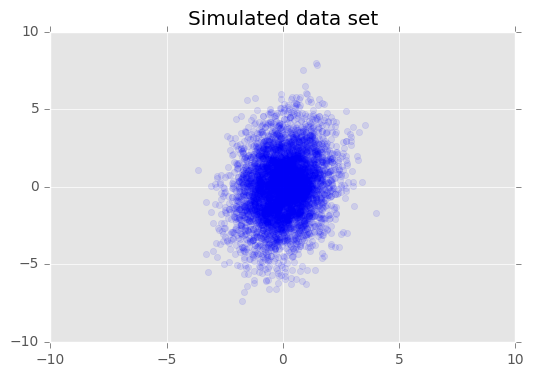

In [37]:
plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.axis([-10, 10, -10, 10])
plt.title("Simulated data set")
plt.show()

## Model

Consider a set of $N$ data points, $X = \{\mathbf{x}_n\}$, where each
data point is $d$-dimensional, $\mathbf{x}_n \in \mathbb{R}^D$.

While our data operates in $D$ dimensions, we will use latent variables
$\mathbf{z}_n \in \mathbb{R}^K$ for each data point $\mathbf{x}_n$
with lower dimension, $K < D$. The set of principal axes
$\mathbf{W}$ relates our latent variables to our actual data.

Specifically, we have that
\begin{equation*}
\mathbf{z} \sim N(0, \mathbf{I}),
\end{equation*}
and that
\begin{equation*}
\mathbf{x} \mid \mathbf{z} \sim N(\mathbf{Wz} + \mu, \sigma^2\mathbf{I}),
\end{equation*}
where $\mathbf{\epsilon} \sim N(0, \sigma^2\mathbf{I})$.

Because of the dependence on $\mathbf{Wz}$, we don't want to solely
want to infer the original principal axes (as would be done in the
vanilla PCA model). Rather, we aim to model the principal axes with
respect to the latent variables.

For our marginal distribution, we get that
\begin{equation*}
x \sim N(0, \mathbf{W}\mathbf{W}^Y + \sigma^2\mathbf{I}).
\end{equation*}

Note here that regular PCA is simply the specific case of
Probabilistic PCA, as $\sigma^2 \to 0$.

We set up our model below, forming creating a prior distribution over
our variables of interest.

In [4]:
# MODEL

w = Normal(mu=tf.zeros([D, K]), sigma=2.0 * tf.ones([D, K]))
z = Normal(mu=tf.zeros([N, K]), sigma=tf.ones([N, K]))
x = Normal(mu=tf.matmul(w, z, transpose_b=True), sigma=tf.ones([D, N]))

## Inference

Since the principal axes $\mathbf{W}$ cannot be analytically
determined, we must use some inference method. Below, we set up our
inference variables and then run a chosen algorithm. For this
example, we minimize the $\text{KL}(q\|p)$ divergence measure.

In [5]:
qw = Normal(mu=tf.Variable(tf.random_normal([D, K])),
            sigma=tf.nn.softplus(tf.Variable(tf.random_normal([D, K]))))
qz = Normal(mu=tf.Variable(tf.random_normal([N, K])),
            sigma=tf.nn.softplus(tf.Variable(tf.random_normal([N, K]))))

inference = ed.KLqp({w: qw, z: qz}, data={x: x_train})
inference.run(n_iter=500, n_print=100, n_samples=10)

Iteration   1 [  0%]: Loss = 37919.180
Iteration 100 [ 20%]: Loss = 17810.891
Iteration 200 [ 40%]: Loss = 17795.408
Iteration 300 [ 60%]: Loss = 17792.107
Iteration 400 [ 80%]: Loss = 17812.242
Iteration 500 [100%]: Loss = 17802.207


## Criticism

We first inspect the model's inferred principal axes.

In [6]:
sess = ed.get_session()
print("Inferred principal axes:")
print(sess.run(qw.mean()))

Inferred principal axes:
[[-0.24093632]
 [-1.76468039]]


The model has recovered the true principal axes up to finite data and
also up to identifiability (there's a symmetry in the
parameterization).

Another way to criticize the model is to visualize the observed data
against data generated from our fitted model. The blue dots represent
the original data, while the red is the inferred.

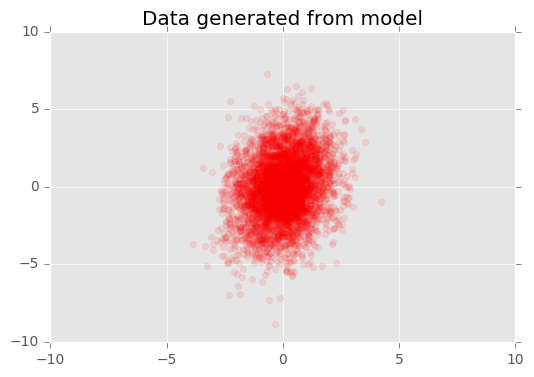

In [35]:
# Build and then generate data from the posterior predictive distribution.
x_post = ed.copy(x, {w: qw, z: qz})
x_gen = sess.run(x_post)

plt.scatter(x_gen[0, :], x_gen[1, :], color='red', alpha=0.1)
plt.axis([-10, 10, -10, 10])
plt.title("Data generated from model")
plt.show()

The generated data looks close to the true data.